# Seminário Predição dados - Humberto Chaves (218060062) e Layla Sampaio (119060009)

# Usando VAR (vetor autorregressivo) para prever dados sobre economia


## Preparandinho o terreno

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = sm.datasets.macrodata.load_pandas().data #cria o dataset puxando da API
data.head(6) # esse dataset se refere a economia de um dado país, no intervalo de tempo de 1959 a 2009 dividido por bimestre

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19
5,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55


## Descrição do problema

O modelo VAR é um processo ESTOCASTICO que representa um grupo de variáveis dependentes de TEMPO como uma FUNÇÂO LINEAR dos valores passados delas próprias e dos valores passados de todas as outras variáveis do grupo.


Por exemplo, podemos considerar uma análise de série temporal bivariada que descreve uma relação entre temperatura de hora em hora e a velocidade do vento em função de valores passados ​​[2]:

temp(t) = a1 + w11* temp(t-1) + w12* vento(t-1) + e1(t-1)

vento(t) = a2 + w21* temp(t-1) + w22* vento(t-1) +e2(t-1)

onde a1 e a2 são constantes; w11, w12, w21 e w22 são os coeficientes; e1 e e2 são os termos de erro

Em nosso problema, usamos o VAR para fazer a previsão do PROODUTO INTERNO BRUTO  e da RENDA PESSOAL DESCARTAVEL num período de tempo de 10 DATAS nesse caso BIMESTRES.

## Apresentação da metodologia

### Tratamento de dados

Nossos dados continham uma série de dados de séries temporais. A solução do Machine Hack escolheu apenas duas variáveis dependentes de tempo (realgdp e realdpi) para fazer o experimento e usou a coluna "year" como índice dos dados

Antes de aplicar o modelo VAR, precisamos verificar se nossas variaveis eram estacionárias (apresentavam média e variânca constantes ao longo do tempo).

Para isso, usamos o teste Augmented Dickey-Fuller (ADF) para encontrar a estacionariedade da série usando os critérios AIC. O teste ADF é um teste de raiz unitária em séries temporais. A estatística ADF, usada no teste, é um número negativo, e quanto mais negativo, mais indicativo o teste se torna de rejeitar a hipótese nula de que existe raiz unitária na série.

Como ambas as séries não são estacionárias, realizamos a diferenciação e posteriormente verificamos a estacionaridade.

Os dados passam a ser estacionários.

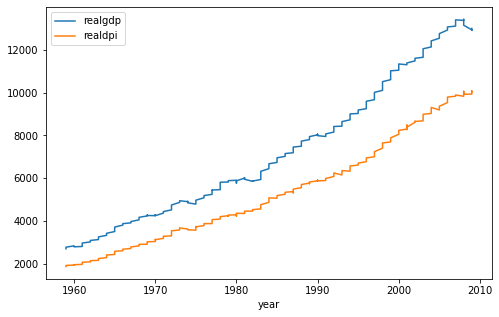

In [ ]:
data1 = data[["realgdp", 'realdpi']]
data1.index = data["year"]
data1.plot(figsize = (8,5))

In [ ]:
adfuller_test = adfuller(data1['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.7504627967647186
p-value: 0.9982455372335032


In [ ]:
adfuller_test = adfuller(data1['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 2.9860253519546855
p-value: 1.0


In [ ]:
data_d = data1.diff().dropna()

In [ ]:
adfuller_test = adfuller(data_d['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658105
p-value: 3.327882187668224e-08


In [ ]:
adfuller_test = adfuller(data_d['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -8.864893340673007
p-value: 1.4493606159108096e-14


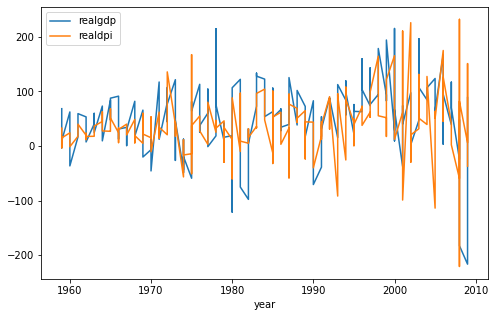

In [ ]:
data_d.plot(figsize=(8,5))

### Sobre o modelo

No processo de modelagem do VAR, o site optou por empregar o Critério de Informação Akaike (AIC) como critério de seleção do modelo para realizar a identificação ótima do modelo. Em termos simples, selecionamos a ordem (p) do VAR com base na melhor pontuação do AIC. O AIC, em geral, penaliza os modelos por serem muito complexos, embora os modelos complexos possam ter um desempenho ligeiramente melhor em algum outro critério de seleção de modelos. Assim, esperamos um ponto de inflexão na busca da ordem (p), significando que, a pontuação do AIC deve diminuir à medida que a ordem (p) aumenta até uma certa ordem e então a pontuação começa a aumentar. Para isso, realizamos grid-search para investigar a ordem ótima (p).

Realizamos a divisão de teste de treinamento dos dados e mantemos as últimas 10 datas como dados de teste. Treinamos o modelo VAR com os dados de treinamento, que foram os separados 10 ultimos bimestres do dataset.

A partir do gráfico, a pontuação de AIC mais baixa é alcançada na ordem de 2 e, em seguida, as pontuações de AIC mostram uma tendência crescente à medida que a ordem p aumenta. Assim, selecionamos o 2 como a ordem ótima do modelo VAR. Consequentemente, ajustamos a ordem 2 ao modelo de previsão.

Ao executar um teste de hipótese, você usa a estatística T com um valor p . O valor-p informa quais são as chances de que seus resultados possam ter acontecido por acaso.

Como não conseguimos compreender muito bem os dados apresentados no sumário, criamos algumas hipoteses:

1) Nos nossos testes, a t-stat pode ser considerada baixa, por isso, consideramos nossa previsão boa.

2) a coluna "prob" pode estar relacionada a probabilidade de erro, e por termos numeros baixos aqui também, imaginamos que nossa previsão tenha se aproximado do real resultado.

In [ ]:
train = data_d.iloc[:-10,:]
test = data_d.iloc[-10:,:]

In [ ]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


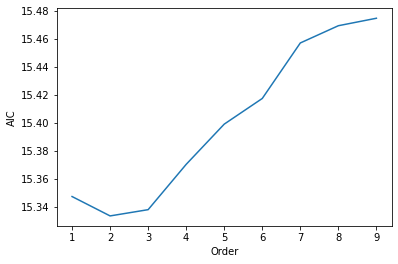

In [ ]:
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Jan, 2022
Time:                     19:25:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

## Discussão dos resultados e conclusões finais




Usamos 2 como a ordem ótima no ajuste do modelo VAR. Assim, tomamos as 2 etapas finais nos dados de treinamento para prever a próxima etapa imediata (ou seja, a primeira data dos dados de teste).

Depois de ajustar o modelo, prevemos para os dados de teste em que as últimas 2 datas de dados de treinamento foram definidas como valores defasados ​​e as steps definidas como 10 datas conforme queremos prever para os próximos 10 dias.

O realdpi original e o realdpi previsto mostram um padrão semelhante fora das datas previstas. Para realgdp: a primeira metade dos valores previstos apresenta um padrão semelhante aos valores originais, por outro lado, a última metade dos valores previstos não segue um padrão semelhante.


In [ ]:
lagged_values = train.values[-2:]#Usamos 2 como a ordem ótima no ajuste do modelo VAR.
                                # Assim, tomamos as 2 ultimas datas dos dados de treinamento para prever a próxima etapa imediata
forecast = pd.DataFrame(results.forecast(y= lagged_values, steps=10),# prevemos para os dados de teste em que as últimas 2 datas de DADOS DE TREINAMENTO
                        index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])#foram definidas como valores defasados ​​e as steps definidas como 10 datas conforme queremos prever para os próximos 10 dias.
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,61.872982,47.739232
2007.0,53.948996,41.742951
2007.0,56.171082,42.552316
2008.0,54.953081,42.023999
2008.0,55.109616,42.001007
2008.0,54.865410,41.937065
2008.0,54.841362,41.893996
2009.0,54.775171,41.878378
2009.0,54.754309,41.859837


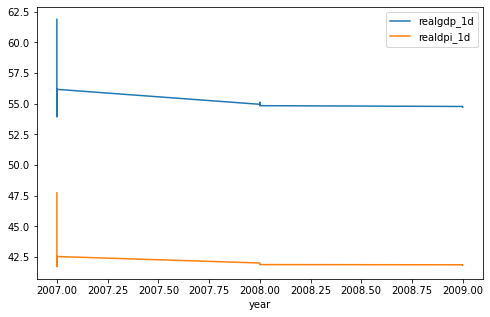

In [ ]:
forecast.plot(figsize=(8,5))


In [ ]:
forecast["realgdp_forecasted"] = data1["realgdp"].iloc[-10-1] + forecast['realgdp_1d'].cumsum() #Derivação da previsão
forecast["realdpi_forecasted"] = data1["realdpi"].iloc[-10-1] + forecast['realdpi_1d'].cumsum() #que soma acumulativa dos valores dos 10 dias anteriores anteriores

In [ ]:
forecast

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,61.872982,47.739232,13161.773982,9877.939232
2007.0,53.948996,41.742951,13215.722978,9919.682183
2007.0,56.171082,42.552316,13271.894060,9962.234500
2008.0,54.953081,42.023999,13326.847141,10004.258499
2008.0,55.109616,42.001007,13381.956757,10046.259506
2008.0,54.865410,41.937065,13436.822166,10088.196571
2008.0,54.841362,41.893996,13491.663528,10130.090566
2009.0,54.775171,41.878378,13546.438699,10171.968945
2009.0,54.754309,41.859837,13601.193008,10213.828781


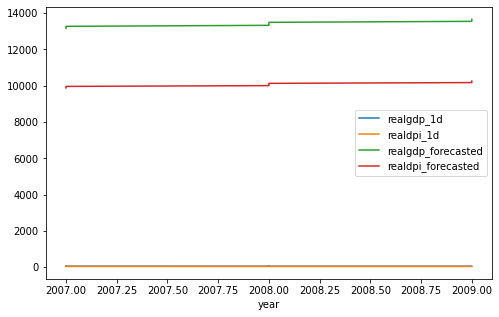

In [ ]:
forecast.plot(figsize=(8,5))

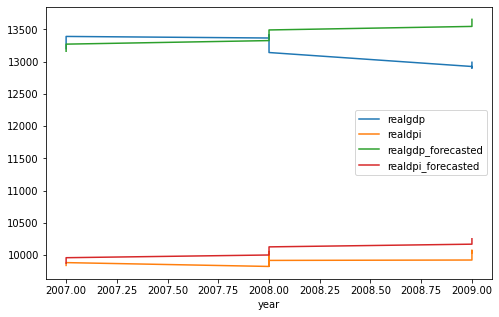

In [ ]:
data1_10 = data1.iloc[-10:,:]
forecasted = forecast[["realgdp_forecasted", "realdpi_forecasted"]]
prev = pd.concat([data1_10, forecasted])
prev.plot(figsize=(8,5)) #PROJEÇÃO CORRETA(modelo da previsao) COM PROPORÇÃO ERRADA